## Dimensionality reduction with principal components

**Principal component analysis**, or **PCA**, is an alternative to regularization and straight-forward feature elimination. PCA is particularly useful for problems with very large numbers of features compared to the number of training cases. For example, when faced with a problem with many thousands of features and perhaps a few thousand cases, PCA can be a good choice to **reduce the dimensionality** of the feature space.  

PCA is one of a family of transformation methods that reduce dimensionality. PCA is the focus here, since it is the most widely used of these methods. 

The basic idea of PCA is rather simple: Find a linear transformation of the feature space which **projects the majority of the variance** onto a few orthogonal dimensions in the transformed space. The PCA transformation maps the data values to a new coordinate system defined by the principal components. Assuming the highest variance directions, or **components**, are the most informative, low variance components can be eliminated from the space with little loss of information. 

The projection along which the greatest variance occurs is called the **first principal component**. The next projection, orthogonal to the first, with the greatest variance is called the **second principal component**. Subsequent components are all mutually orthogonal with decreasing variance along the projected direction.  

Widely used PCA algorithms compute the components sequentially, starting with the first principal component. This means that it is computationally efficient to compute the first several components from a very large number of features. Thus, PCA can make problems with very large numbers of features computationally tractable. 

****
**Note:** It may help your understanding to realize that principal components are a scaled version of the **eigenvectors** of the feature matrix. The scale for each dimensions is given by the **eigenvalues**. The eigenvalues are the fraction of the variance explained by the components. 
****

## A simple example

To cement the concepts of PCA you will now work through a simple example. This example is restricted to 2-d data so that the results are easy to visualize. 

As a first step, execute the code in cell below to load the packages required for the rest of this notebook.

> **Note:** If you are running in Azure Notebooks, make sure that you run the code in the `setup.ipynb` notebook at the start of you session to ensure your environment is correctly configured. 

In [1]:
## Import packages
library(ggplot2)
library(repr)
library(dplyr)
library(caret)
library(MASS)
library(ROCR)
library(pROC)

options(repr.plot.width=4, repr.plot.height=4) # Set the initial plot area dimensions


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



The code in the cell below simulates data from a bivariate Normal distribution. The distribution is deliberately centered on $\{ 0,0 \}$ and with unit variance on each dimension. There is considerable covariance between the two dimensions leading to a covariance matrix:

$$cov(X) =  \begin{bmatrix}
  1.0 & 0.6 \\
  0.6 & 1.0
 \end{bmatrix}$$

Given the covariance matrix 100 draws from this distribution are computed using the `mvrnorm` function from the R MASS package. Execute this code:

In [2]:
set.seed(124)
cov = matrix(c(1.0, 0.6, 0.6, 1.0), nrow =2, ncol = 2)
mean = c(0.0, 0.0)

sample = data.frame(mvrnorm(n = 100, mu = mean, Sigma = cov))
names(sample) = c('x','y')
print(dim(sample))
head(sample)

[1] 100   2


x,y
-1.0289674,-1.44872226
0.5476797,-0.47912514
-1.1761978,-0.18875203
0.3192489,0.06053589
1.3990650,1.15101479
1.0575449,0.27422109


To get a feel for this data, execute the code in the cell below to display a plot and examine the result. 

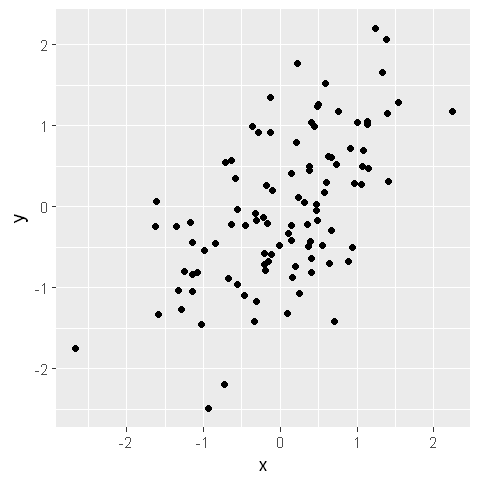

In [3]:
ggplot(sample, aes(x,y)) + geom_point()

You can see that the data have a roughly elliptical pattern. The correlation between the two dimensions is also visible. 

With the simulated data set created, it is time to compute the PCA model. The code in the cell below computes the principle component model using the R `prcomp` function. This function contains a list with multiple elements including the eigenvalues. The eigenvalues can be scaled to compute the variance explained:

$$VE(X) = \frac{Var_{X-component}(X)}{Var_{X-total}(X)}$$

Notice that by construction:

$$VE(X) = \sum_{i=1}^N VE_i(X) = 1.0$$

In other words, the sum of the variance explained for each component must add to the total variance or 1.0 for standardized data. 

Execute this code and examine the result.

In [4]:
pca_mod = prcomp(sample)
pca_mod

Standard deviations:
[1] 1.1197401 0.5688762

Rotation:
        PC1        PC2
x 0.6595985 -0.7516182
y 0.7516182  0.6595985

Notice that the standard deviation of the first component is several times larger than for the second component. This is exactly the desired result indicating the first principal component explains the majority of the variance of the sample data. Mathematically the components are the eigenvectors and the standard deviations are  the eigenvalues of the data covariance matrix. 

The code in the cell below computes and prints the scaled magnitude of the components. These scaled components must add to 1.0. Execute this code:  

In [5]:
sdev_scaled = pca_mod$sdev**2/sum(pca_mod$sdev**2)
sdev_scaled

[1] 0.7948445 0.2051555

The components are scaled by element wise multiplication with percent variance explained. Execute this code and examine the results. 

In [6]:
scaled_pca = data.frame(matrix(c(0,0,0,0), nrow = 2, ncol = 2))
for(i in 1:2){
    scaled_pca[i,] = pca_mod$rotation[i,] * sdev_scaled
}
names(scaled_pca) = c('PC1','PC2')
str(scaled_pca)

'data.frame':	2 obs. of  2 variables:
 $ PC1: num  0.524 0.597
 $ PC2: num  -0.154 0.135


The two component vectors have their origins at $[ 0,0 \}$, and are quite different magnitude, and are pointing in different directions. To better understand how the projections of the components relate to the data, execute the code to plot the data along with the principal components. Execute this code: 

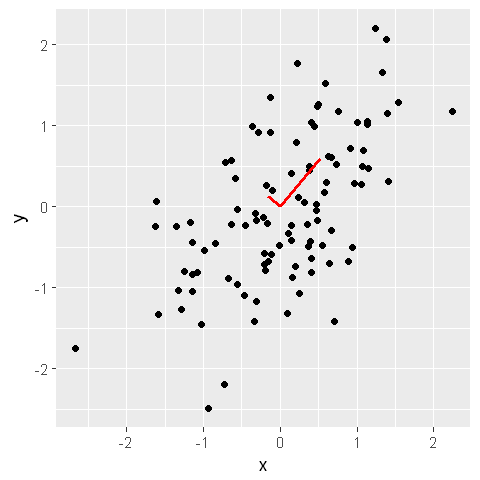

In [7]:
## Find the slopes
s1 = data.frame(x = c(0.0, scaled_pca$PC1[1]), y = c(0.0, scaled_pca$PC1[2]))
s2 = data.frame(x = c(0.0, scaled_pca$PC2[1]), y = c(0.0, scaled_pca$PC2[2]))

## Plot the data with the PCs
ggplot(sample, aes(x,y)) + geom_point() +
        geom_line(data = s1, aes(x,y), color = 'red', size = 1) +
        geom_line(data = s2, aes(x,y), color = 'red', size = 1)

Notice the the first principal component (the long red line) is along the direction of greatest variance of the data. This is as expected. The short red line is along the direction of the second principal component. The lengths of these lines are the variance in the directions of the projection. 

The ultimate goal of PCA is to transform data to a coordinate system with the highest variance directions along the axes. The `transform` function in the cell below computes the projections of the data onto the new coordinate frames using matrix multiplication. Execute this code to apply the transform and plot the result: 

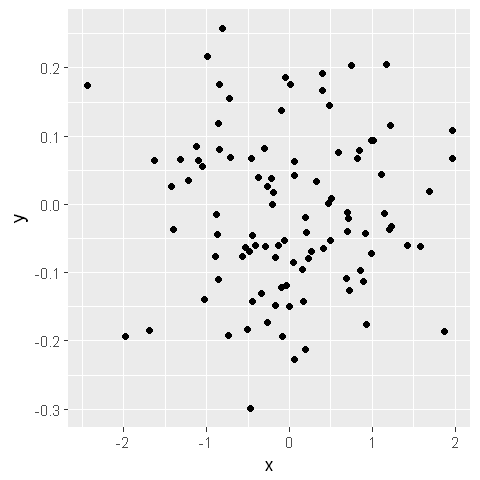

In [8]:
pca_transform = function(df, pca, ncomps){
    data.frame(as.matrix(df) %*% as.matrix(pca)[,1:ncomps])
}

trans_sample = pca_transform(sample, scaled_pca, 2)
names(trans_sample) = c('x', 'y')
ggplot(trans_sample, aes(x,y)) + geom_point()

Notice that the scale along these two coordinates are quite different. The first principal component is along the horizontal axis. The range of values on this direction is in the range of about $\{ -2.5,2.5 \}$. The range of values on the vertical axis or second principal component are only about $\{ -0.2, 0.3 \}$. It is clear that most of the variance is along the direction of the fist principal component. 

## Load Features and Labels

Keeping the foregoing simple example in mind, it is time to apply PCA to some real data. 

The code in the cell below loads the dataset which has the following preprocessing:
1. Cleaning missing values.
2. Aggregating categories of certain categorical variables. 

Execute the code in the cell below to load the dataset: 

In [9]:
credit = read.csv('German_Credit_Preped.csv', header = TRUE)
credit[,'Customer_ID'] = NULL
credit$bad_credit <- ifelse(credit$bad_credit == 1, 'bad', 'good')
credit$bad_credit <- factor(credit$bad_credit, levels = c('bad', 'good'))
dim(credit)
str(credit)

[1] 1000   21

'data.frame':	1000 obs. of  21 variables:
 $ checking_account_status : Factor w/ 4 levels "< 0 DM","> 200 DM or salary assignment",..: 1 3 4 1 1 4 4 3 4 3 ...
 $ loan_duration_mo        : int  6 48 12 42 24 36 24 36 12 30 ...
 $ credit_history          : Factor w/ 5 levels "all loans at bank paid",..: 2 3 2 3 5 3 3 3 3 2 ...
 $ purpose                 : Factor w/ 10 levels "business","car (new)",..: 8 8 5 6 2 5 6 3 8 2 ...
 $ loan_amount             : int  1169 5951 2096 7882 4870 9055 2835 6948 3059 5234 ...
 $ savings_account_balance : Factor w/ 5 levels "< 100 DM",">= 1000 DM",..: 5 1 1 1 1 5 4 1 2 1 ...
 $ time_employed_yrs       : Factor w/ 5 levels "< 1 year",">= 7 years",..: 2 3 4 4 3 3 2 3 4 5 ...
 $ payment_pcnt_income     : int  4 2 2 2 3 2 3 2 2 4 ...
 $ gender_status           : Factor w/ 4 levels "female-divorced/separated/married",..: 4 1 4 4 4 4 4 4 2 3 ...
 $ other_signators         : Factor w/ 3 levels "co-applicant",..: 3 3 3 2 3 3 3 3 3 3 ...
 $ time_in_residence    

There are 20 features in this data set. 

The prcomp function can only work with numeric matrices. Therefore, the categorical features are dummy variable encoded. Executed the code in the cell below to compute the encoding for the dummy variables. 

In [10]:
dummies = dummyVars(bad_credit ~ ., data = credit)

The code in the cell below to split the data set into test and training subsets and dummy variable encode the categorical features. The Caret `createDataPartion` function is used  to randomly split the dataset. The `perdict` method dummy variable encodes the categorical features. Execute this code and examine the result. 

In [11]:
set.seed(1955)
## Randomly sample cases to create independent training and test data
partition = createDataPartition(credit[,'bad_credit'], times = 1, p = 0.7, list = FALSE)
training = credit[partition,] # Create the training feature sample
training_label = credit[partition, 'bad_credit'] # Subset training labels
training = predict(dummies, newdata = training) # transform categorical to dummy vars
dim(training)
test = credit[-partition,] # Create the test sample
test_label = credit[-partition, 'bad_credit'] # Subset training labels
test = predict(dummies, newdata = test) # transform categorical to dummy vars
dim(test)
head(training)

Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$lvls):
"variable 'bad_credit' is not a factor"

[1] 700  61

Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$lvls):
"variable 'bad_credit' is not a factor"

[1] 300  61

,checking_account_status.< 0 DM,checking_account_status.> 200 DM or salary assignment,checking_account_status.0 - 200 DM,checking_account_status.none,loan_duration_mo,credit_history.all loans at bank paid,credit_history.critical account - other non-bank loans,credit_history.current loans paid,credit_history.no credit - paid,credit_history.past payment delays,...,number_loans,job_category.highly skilled,job_category.skilled,job_category.unemployed-unskilled-non-resident,job_category.unskilled-resident,dependents,telephone.none,telephone.yes,foreign_worker.no,foreign_worker.yes
1,1,0,0,0,6,0,1,0,0,0,...,2,0,1,0,0,1,0,1,0,1
3,0,0,0,1,12,0,1,0,0,0,...,1,0,0,0,1,2,1,0,0,1
4,1,0,0,0,42,0,0,1,0,0,...,1,0,1,0,0,2,1,0,0,1
5,1,0,0,0,24,0,0,0,0,1,...,2,0,1,0,0,2,1,0,0,1
7,0,0,0,1,24,0,0,1,0,0,...,1,0,1,0,0,1,1,0,0,1
8,0,0,1,0,36,0,0,1,0,0,...,1,1,0,0,0,1,0,1,0,1


Before preforming PCA all features must be zero mean and unit variance. Failure to do so will result in biased computation of the components and scales. The `preProcess` function from Caret is used to compute scaling of the training data. The same scaling is applied to the test data. Execute the code in the cell below to scale the features. 

In [12]:
num_cols = c('loan_duration_mo', 'loan_amount', 'payment_pcnt_income', 'age_yrs')
preProcValues <- preProcess(training[,num_cols], method = c("center", "scale"))

training[,num_cols] = predict(preProcValues, training[,num_cols])
test[,num_cols] = predict(preProcValues, test[,num_cols])
head(training[,num_cols])

,loan_duration_mo,loan_amount,payment_pcnt_income,age_yrs
1,-1.2111310,-0.7137211,0.91818241,2.6286850
3,-0.7100721,-0.3883552,-0.88723244,1.0922267
4,1.7952226,1.6424615,-0.88723244,0.7507916
5,0.2920458,0.5852856,0.01547498,1.4336619
7,0.2920458,-0.1289751,0.01547498,1.4336619
8,1.2941637,1.3146387,-0.88723244,-0.1027964


## Compute principal components

The code in the cell below computes the principal components for the training feature subset. Execute this code:

In [13]:
pca_credit = prcomp(training)

Execute the code in the cell below to print the variance explained for each component and the sum of the variance explained:

In [14]:
var_exp = pca_credit$sdev**2/sum(pca_credit$sdev**2)
var_exp
sum(var_exp)

[1] 1.497309e-01 1.236366e-01 8.657364e-02 7.430983e-02 4.654524e-02
 [6] 3.969042e-02 3.376930e-02 3.081667e-02 2.799565e-02 2.767094e-02
[11] 2.473425e-02 2.387016e-02 2.179073e-02 2.131084e-02 1.928398e-02
[16] 1.862056e-02 1.733272e-02 1.638087e-02 1.504242e-02 1.475756e-02
[21] 1.304725e-02 1.203826e-02 1.152212e-02 1.103266e-02 1.026662e-02
[26] 9.328127e-03 9.073922e-03 8.698250e-03 8.050771e-03 7.345630e-03
[31] 6.631525e-03 6.097131e-03 5.874018e-03 5.498612e-03 5.081755e-03
[36] 4.685805e-03 4.347963e-03 4.290320e-03 4.119201e-03 3.753746e-03
[41] 3.216549e-03 2.846130e-03 2.520605e-03 2.233028e-03 1.594583e-03
[46] 1.186429e-03 9.107109e-04 8.449461e-04 3.194308e-32 2.407087e-33
[51] 2.084684e-33 1.132497e-33 9.893439e-34 9.105772e-34 6.110785e-34
[56] 6.110785e-34 6.110785e-34 6.110785e-34 6.110785e-34 1.943971e-34
[61] 1.316927e-34

[1] 1

These numbers are a bit abstract. However, you can see that the variance ratios are in descending order and that the sum is 1.0. 

Execute the code in the cell below to create a plot of the explained variance vs. the component:  

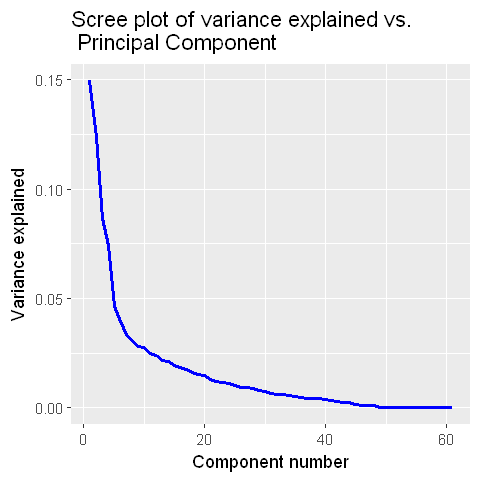

In [15]:
plot_scree = function(pca_mod){
    ## Plot as variance explained
    df = data.frame(x = 1:length(var_exp), y = var_exp)
    ggplot(df, aes(x,y)) + geom_line(size = 1, color = 'blue') +
    xlab('Component number') + ylab('Variance explained') +
    ggtitle('Scree plot of variance explained vs. \n Principal Component')
}

plot_scree(pca_credit)

This curve is often referred to as a **scree plot**. Notice that the explained variance decreases rapidly until the 10th component and then slowly, thereafter. The first few components explain a large fraction of the variance and therefore contain much of the explanatory information in the data. The components with small explained variance are unlikely to contain much explanatory information. Often the inflection point or 'knee' in the scree curve is used to choose the number of components selected. 

Now it is time to create a PCA model with a reduced number of components. The code in the cell below trains and fits a PCA model with 10 components, and then transforms the features using that model. Execute this code. 

In [16]:
## Compute first 10 PCA components 
pca_credit_10 = prcomp(training, rank = 10)

## Scale the eigenvalues
var_exp_10 = pca_credit_10$sdev**2/sum(pca_credit_10$sdev**2)
Nrow = nrow(pca_credit_10$rotation)
Ncol = ncol(pca_credit_10$rotation)
scaled_pca_10 = data.frame(matrix(rep(0, Nrow * Ncol), nrow = Nrow, ncol = Ncol))

## Scale the rotations
for(i in 1:Nrow){
    scaled_pca_10[i,] = pca_credit_10$rotation[i,] * var_exp_10[1:Ncol]
}

## Print the dimensions of the scalled rotations and the first component
dim(scaled_pca_10)
pca_credit_10$rotation[1:10,1]

Warning message:
"In prcomp.default(training, rank = 10) :
 extra argument 'rank' will be disregarded"

[1] 61 61

checking_account_status.< 0 DM 
                                          0.0041824262 
 checking_account_status.> 200 DM or salary assignment 
                                         -0.0170404247 
                    checking_account_status.0 - 200 DM 
                                          0.0130986240 
                          checking_account_status.none 
                                         -0.0002406256 
                                      loan_duration_mo 
                                          0.5912636284 
                 credit_history.all loans at bank paid 
                                          0.0047481403 
credit_history.critical account - other non-bank loans 
                                          0.0233886633 
                     credit_history.current loans paid 
                                         -0.0757636814 
                       credit_history.no credit - paid 
                                          0.0182902560 
                    credit_history.past payment delays 
                                          0.0293366218

The scaled rotation matrix has dimensions of 61 rows and 10 columns. You can see the first 10 elements of the first rotation. Multiplying these numbers by the features rotate each row (case) to the new coordinate system.

## Compute and evaluate a logistic regression model

Next, you will compute and evaluate a logistic regression model using the features transformed by the first 10 principal components. The code in the cell below performs the matrix multiplication between the features and on the 

In [17]:
training_10 = training %*% as.matrix(scaled_pca_10)
dim(training_10)

[1] 700  61

There are now 10 transformed features. 

Now you will now construct and evaluate a logistic regression model by executing the code below:

In [18]:
## Construct a data frame with the transformed features and label
training_10 = data.frame(training_10)
training_10[,'bad_credit'] = training_label

## Create a weight vector for the training cases.
weights = ifelse(training_10$bad_credit == 'bad', 0.66, 0.34)

## Define and fit the logistic regression model
set.seed(5566)
logistic_mod_10 = glm(bad_credit ~ ., data = training_10, 
                      weights = weights, family = quasibinomial)
logistic_mod_10$coefficients

(Intercept)            X1            X2            X3            X4 
    1.6324699    -2.0659917    -2.7031243    -4.5811040     6.5074483 
           X5            X6            X7            X8            X9 
   12.1618677   -24.1136810    26.9863920     9.8167067    -1.6625538 
          X10           X11           X12           X13           X14 
  -14.4728464    25.6719957    21.0768349    24.2732739   -11.5897985 
          X15           X16           X17           X18           X19 
    0.1562231    -5.4541501   -23.5935518     1.0047592    -0.3505837 
          X20           X21           X22           X23           X24 
  -30.8402051    38.1167066    -7.5615764     2.9283656   -17.8233167 
          X25           X26           X27           X28           X29 
   10.5407173    44.2227815    -7.8726321    30.0615595    45.5329259 
          X30           X31           X32           X33           X34 
   86.9515280    70.5349649  -144.2061472    13.5551369   100.7190689 
          X35           X36           X37           X38           X39 
  117.1660687    27.1015228   -56.4379277   184.5588749    57.9523096 
          X40           X41           X42           X43           X44 
  146.6424785  -240.7000002  -105.5569156   -27.0799741   264.5699889 
          X45           X46           X47           X48           X49 
 -267.1956307  1026.0414642  1267.2865319 -1008.5241056            NA 
          X50           X51           X52           X53           X54 
           NA            NA            NA            NA            NA 
          X55           X56           X57           X58           X59 
           NA            NA            NA            NA            NA 
          X60           X61 
           NA            NA

Notice that there are now 10 regression coefficients, one for each component plus an intercept. This number is in contrast to the 61 features in the dummy variable array. 

In order to test the model, the test feature array must also be transformed. Execute the code in the cell below to apply the PCA transformation to the test features:

In [19]:
test_10 = test %*% as.matrix(scaled_pca_10)
test_10 = data.frame(test_10)
test_10[,'bad_credit'] = test_label
dim(test_10)

[1] 300  62

Execute the code in the cell below to score the model using the test data:

In [20]:
score_model = function(df, threshold){
    df$score = ifelse(df$probs < threshold, 'bad', 'good')
    df
}

test_10$probs = predict(logistic_mod_10, newdata = test_10, type = 'response')
test_10 = score_model(test_10, 0.5)
test_10[1:10, c('bad_credit','probs', 'score')]

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

,bad_credit,probs,score
2,bad,0.2558205,bad
6,good,0.6838830,good
17,good,0.9438269,good
21,good,0.8328900,good
24,good,0.8836840,good
27,good,0.7313613,good
28,good,0.6787652,good
30,bad,0.2475953,bad
32,good,0.2717953,bad
33,good,0.5048484,good


Execute the code in the cell below to evaluate the 10 PCA component logistic regression model.

Then, answer **Question 1** on the course page.

                Negative Positive
Actual Negative      171       39
Actual Positive       28       62

accuracy  = 0.777 
precision = 0.614 
recall    = 0.689 
F1        = 0.649 
AUC       = 0.823 


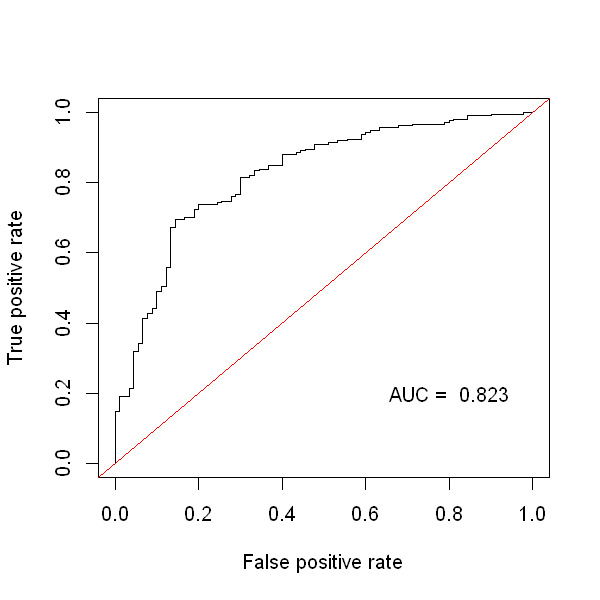

In [21]:
logistic.eval <- function(df){ 
  # First step is to find the TP, FP, TN, FN cases
  df$conf = ifelse(df$bad_credit == 'bad' & df$score == 'bad', 'TP',
                    ifelse(df$bad_credit == 'bad' & df$score == 'good', 'FN',
                           ifelse(df$bad_credit == 'good' & df$score == 'good', 'TN', 'FP')))

  # Elements of the confusion matrix
  TP = length(df[df$conf == 'TP', 'conf'])
  FP = length(df[df$conf == 'FP', 'conf'])
  TN = length(df[df$conf == 'TN', 'conf'])
  FN = length(df[df$conf == 'FN', 'conf'])
  
  ## Confusion matrix as data frame
  out = data.frame(Negative = c(TN, FN), Positive = c(FP, TP))
  row.names(out) = c('Actual Negative', 'Actual Positive')
  print(out)  
  
  # Compute and print metrics
  P = TP/(TP + FP)
  R = TP/(TP + FN)  
  F1 = 2*P*R/(P+R)  
  cat('\n')
  cat(paste('accuracy  =', as.character(round((TP + TN)/(TP + TN + FP + FN), 3)), '\n'))      
  cat(paste('precision =', as.character(round(P, 3)), '\n'))     
  cat(paste('recall    =', as.character(round(R, 3)), '\n'))
  cat(paste('F1        =', as.character(round(F1,3)),'\n'))
    
  roc_obj <- roc(df$bad_credit, df$probs)
  cat(paste('AUC       =', as.character(round(auc(roc_obj),3)),'\n'))
}

ROC_AUC = function(df){
    options(repr.plot.width=5, repr.plot.height=5)
    pred_obj = prediction(df$probs, df$bad_credit)
    perf_obj <- performance(pred_obj, measure = "tpr", x.measure = "fpr")
    AUC = performance(pred_obj,"auc")@y.values[[1]] # Access the AUC from the slot of the S4 object
    plot(perf_obj)
    abline(a=0, b= 1, col = 'red')
    text(0.8, 0.2, paste('AUC = ', as.character(round(AUC, 3))))
}

logistic.eval(test_10)
ROC_AUC(test_10)

These results are reasonably good. Recall, accuracy and AUC have reasonable values, however precision and F1 are low. Is it possible that more PCA components are required to achieve a good model? 

## Add more components to the model

Now you will compute and evaluate a logistic regression model using the first 20 principal components. You will compare this model to the one created with 10 principal components. 

Execute the code below to transform the training features using the first 20 principal components. 

In [22]:
## Compute first 10 PCA components 
pca_credit_20 = prcomp(training, rank = 20)

## Scale the eigenvalues
var_exp_20 = pca_credit_20$sdev**2/sum(pca_credit_20$sdev**2)
Nrow = nrow(pca_credit_20$rotation)
Ncol = ncol(pca_credit_20$rotation)
scaled_pca_20 = data.frame(matrix(rep(0, Nrow * Ncol), nrow = Nrow, ncol = Ncol))

## Scale the rotations
for(i in 1:Nrow){
    scaled_pca_20[i,] = pca_credit_20$rotation[i,] * var_exp_20[1:Ncol]
}

## Print the dimensions of the scalled rotations and the first component
dim(scaled_pca_20)

Warning message:
"In prcomp.default(training, rank = 20) :
 extra argument 'rank' will be disregarded"

[1] 61 61

There are now 20 components in the PCA model. 

The code in the cell below computes the transformed feature set and creates a logistic regression model from this feature set. Execute this code.

In [23]:
## Construct a data frame with the transformed features and label
training_20 = training %*% as.matrix(scaled_pca_20)
training_20 = data.frame(training_20)
training_20[,'bad_credit'] = training_label

weights = ifelse(training_20$bad_credit == 'bad', 0.66, 0.34)

## Define and fit the logistic regression model
set.seed(5566)
logistic_mod_20 = glm(bad_credit ~ ., data = training_20, 
                      weights = weights, family = quasibinomial)
logistic_mod_20$coefficients

(Intercept)            X1            X2            X3            X4 
    1.6324699    -2.0659917    -2.7031243    -4.5811040     6.5074483 
           X5            X6            X7            X8            X9 
   12.1618677   -24.1136810    26.9863920     9.8167067    -1.6625538 
          X10           X11           X12           X13           X14 
  -14.4728464    25.6719957    21.0768349    24.2732739   -11.5897985 
          X15           X16           X17           X18           X19 
    0.1562231    -5.4541501   -23.5935518     1.0047592    -0.3505837 
          X20           X21           X22           X23           X24 
  -30.8402051    38.1167066    -7.5615764     2.9283656   -17.8233167 
          X25           X26           X27           X28           X29 
   10.5407173    44.2227815    -7.8726321    30.0615595    45.5329259 
          X30           X31           X32           X33           X34 
   86.9515280    70.5349649  -144.2061472    13.5551369   100.7190689 
          X35           X36           X37           X38           X39 
  117.1660687    27.1015228   -56.4379277   184.5588749    57.9523096 
          X40           X41           X42           X43           X44 
  146.6424785  -240.7000002  -105.5569156   -27.0799741   264.5699889 
          X45           X46           X47           X48           X49 
 -267.1956307  1026.0414642  1267.2865319 -1008.5241056            NA 
          X50           X51           X52           X53           X54 
           NA            NA            NA            NA            NA 
          X55           X56           X57           X58           X59 
           NA            NA            NA            NA            NA 
          X60           X61 
           NA            NA

The code in the cell below scores the logistic regression model and displays performance metrics, the ROC curve, and the AUC. Execute this code and examine the result. 

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

                Negative Positive
Actual Negative      171       39
Actual Positive       28       62

accuracy  = 0.777 
precision = 0.614 
recall    = 0.689 
F1        = 0.649 
AUC       = 0.823 


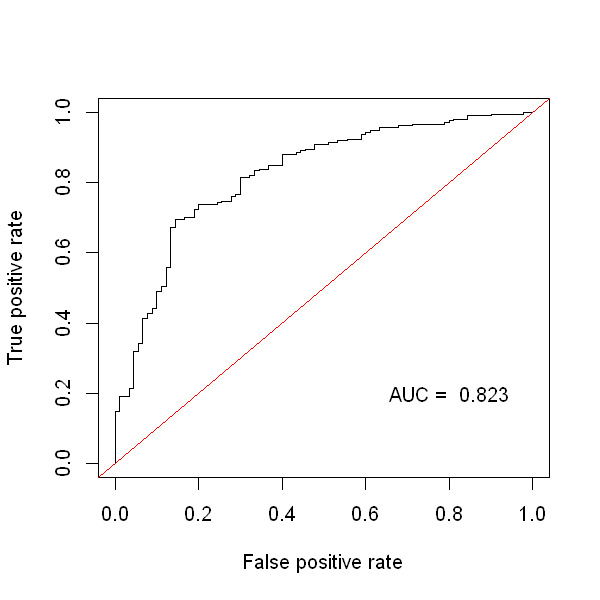

In [24]:
## Create the transformed test dataset
test_20 = test %*% as.matrix(scaled_pca_20)
test_20 = data.frame(test_20)
test_20[,'bad_credit'] = test_label

## Score the model
test_20$probs = predict(logistic_mod_20, newdata = test_20, type = 'response')
test_20 = score_model(test_20, 0.5)

## Evaluate the model
logistic.eval(test_20)
ROC_AUC(test_20)

The metrics for the 20 component model are nearly the same as for the 10 component model. It appears that 10 components is enough to represent the information in the feature set. 

## Summary

In this lab you have applied principal component analysis to dimensionality reduction for supervised machine learning. The first components computed contain most of the available information. When faced with large number of features, PCA is an effective way to make supervised machine learning models tractable. 

Specifically in this lab you have:
1. Computed PCA models with different numbers of components.
2. Compared logistic regression models with different numbers of components. In this case, using 10 components produced a good model. Extending this to 20 components gained little if anything. In summary the dimensionality of the original 61 dummy variable array to just 10 components. 